# Computing Visions Movie Studios
#### Analysts: Allie Garrison, Cameron Narimanian, Cole Sussmeier, Matthew Rodberg, Ari Palacios

### Overview
> The most important thing for an emerging movie company is to know what movies made money. To this end, we decided to research which genre of movies Computing Vision should invest in by looking at profitability and return on investment (ROI). We also explored which budget brackets would deliver the best return, and which runtime would be optimal. We also organized our repository with our own personal workbooks in the main repository that we used as sandboxes before putting our final code into the Primary Notebook which is our final deliverable. In our repository we also included an ERD for our reference.

### Business Understanding
>Profit at the end of the day is the goal for all companies and therefore when starting a movie company, it is important to know which movie products make money. Therefore, our objective is to find the optimal movie type and structure that will optimize profits. To achieve this, we must examine the key metrics of a movie, namely genre, runtime, and budget.
### Data Understanding and Analysis
>We drew our data from our available datasets, with our group using im.db.zip and tn.movie_budgets.csv wherein we merged these data sets into a single Pandas data frame where we all then draw our analysis from. This data frame served as the foundation for the rest of our analysis

### Importing packages


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

### Reading in Data

In [2]:
## Creating a connection to the imdb SQL database
conn = sqlite3.connect('zippedData/im.db')

## Reading in datasets
bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t',encoding='windows-1252')
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv")
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", parse_dates=['release_date'])

### Cleaning Data
>A copy of the tn_movie_budgets dataframe was made to use for cleaning.<br />
New columns were made to hold the cleaned versions of production_budget, domestic_gross, and worldwide_gross.<br />
These were also transformed to be in millions of dollars.<br />
All movies released before 2010 were removed because they are not relevant to the recomendations.<br />
All movies that did not make a profit were also removed.

In [3]:
## Making copy of movie budgets data frame for cleaning
tn_movie_budgets_clean = tn_movie_budgets.copy()

## turning the columns with dollar amounts into int types in millions of dollars
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross_in_millions'].astype('int64') / 1000000

## taking out all movies that were released before January 1, 2010
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['release_date'] >= "2010-01-01"]

## taking out all movies that did not make a profit
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['domestic_gross_in_millions'] != 0]

### Creating Features
> Return on Investment (ROI) columns were added for both international and domestic gross. <br />
A profit column was added using the worldwide gross and production budget.

In [4]:
## Creating columns with return on investment (ROI) for domestic and international revenue
tn_movie_budgets_clean['ROI_domestic'] = (tn_movie_budgets_clean['domestic_gross_in_millions'] / 
                                          tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean['ROI_international'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] / 
                                               tn_movie_budgets_clean['production_budget_in_millions']) * 100

# create profit column
tn_movie_budgets_clean['profit_in_millions'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] - 
                                                tn_movie_budgets_clean['production_budget_in_millions'])

### Creating Dataframe from im.db
> A pandas dataframe was created using primary_title, runtime_minutes, genres, averagerating, and numvotes. <br />
The tables movie_basics and movie_ratings were joined using the primary key movie_id.

In [5]:
## joining movie_basics and movie_ratings to create a data frame with title, runtime, genre, ratings, and votes
table_genre = pd.read_sql('''
SELECT mb.primary_title, 
        mb.runtime_minutes, 
        mb.genres, 
        mr.averagerating,
        mr.numvotes
FROM movie_basics AS mb
JOIN movie_ratings AS mr USING (movie_id)
''', conn)

### Merging Dataframes
> The table_genre dataframe was merged with the tn_movie_budgets_clean dataframe using the name of the movie

In [6]:
## merging the cleaned tn.movie_budgets dataframe with table_genre on movie title
genre_ratings_budget = tn_movie_budgets_clean.merge(table_genre, how='inner', left_on='movie', right_on='primary_title')

### Exploring Data
> We are looking at the average profit by genre of movie

In [7]:
# genre_hash is a dictionary where each key is a genre, 
# and the value is the number of times it occurs in the 'genres' column
genre_hash = {}

# array of lists where each individual list is every genre listed for a single movie
genre_lists = genre_ratings_budget['genres'].str.split(',')

for i, genres in enumerate(genre_lists):
    # try/ except in case there is an empty list (no genres listed for a movie)
    try:
        for genre in genres:
            # add one to genre if the key exists
            if genre in genre_hash.keys():
                genre_hash[genre] += 1
            # otherwise create the key
            else:
                genre_hash[genre] = 1
    except:
        pass

In [8]:
genre_stats = []
for genre in genre_hash.keys():
    #filter for every entry that contains the current genre
    mask = genre_ratings_budget[genre_ratings_budget['genres'].str.contains(genre) == True]
    # append list with averages for relevant features
    genre_stats.append([genre, mask['profit_in_millions'].mean().round(2), 
                        mask['production_budget_in_millions'].mean().round(2),
                        mask['averagerating'].mean().round(2),
                        mask['numvotes'].mean().round(2)])

In [9]:
#convert to dataframe
genre_stats_df = pd.DataFrame(genre_stats, 
                              columns=['Genre', 'Average_Profit', 'Average_Budget', 'Average_Rating', 'Average_Votes'])

In [10]:
# important note: There are many instances where genres overlap, ie Avengers Endgame is action and adventure.
# This means that the profit of this individual movie is factored into the averages for both genres 
# and they are not independent measures

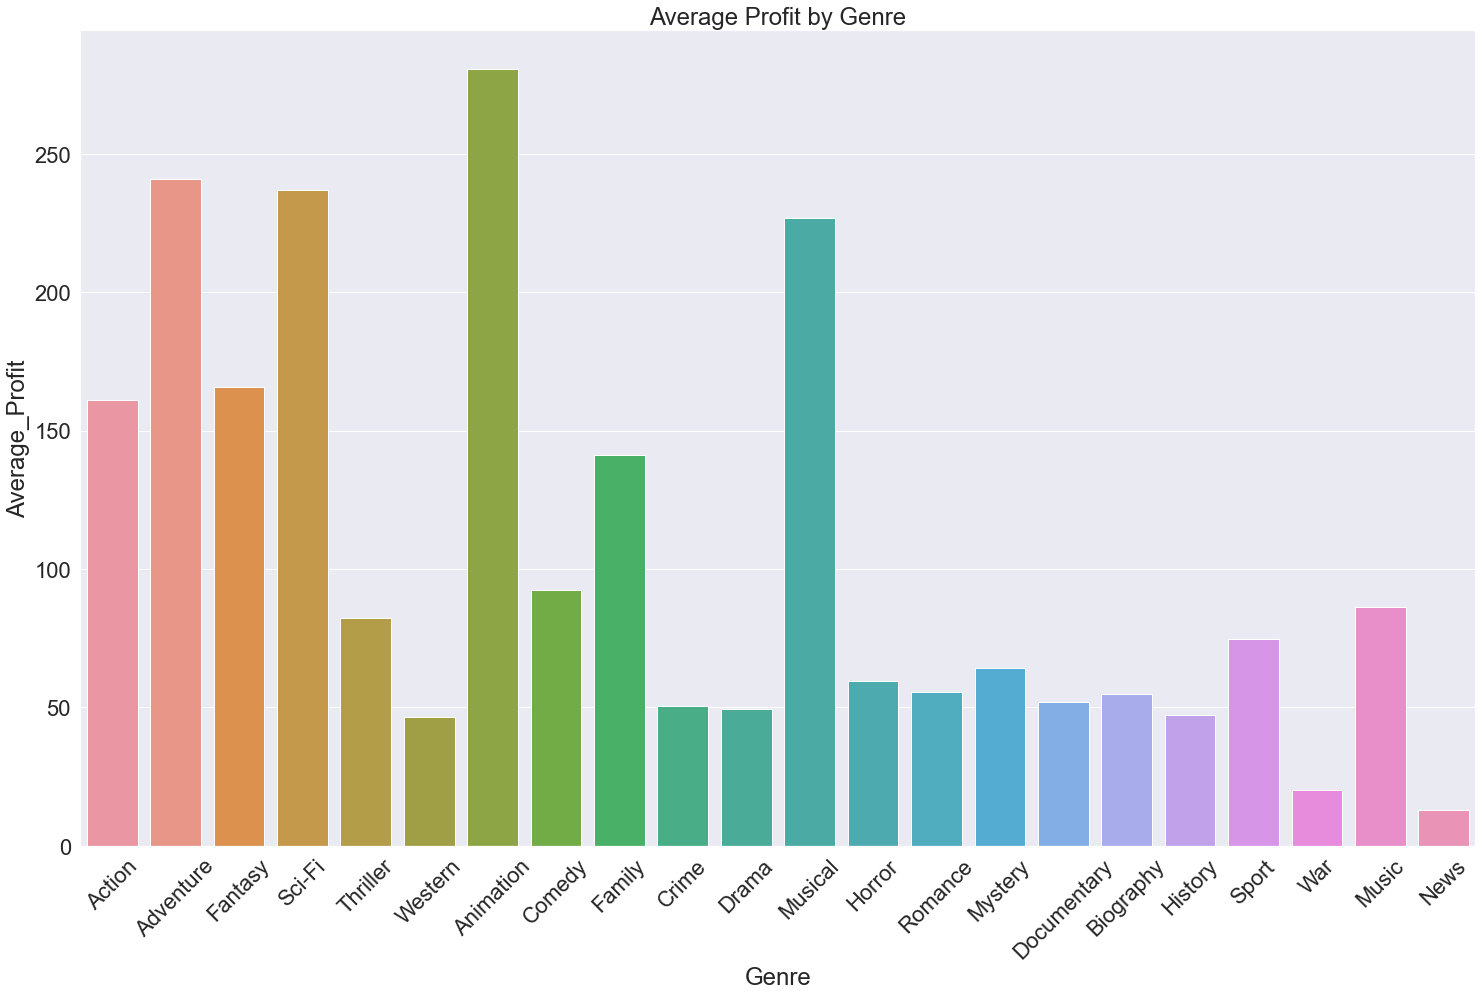

In [11]:
plt.figure(figsize=(25,15))
sns.set(font_scale=2)
plt.xticks(rotation=45)
plt.title("Average Profit by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Profit');

### Choosing First Recomendation
> The above graph shows the average profit of each genre of movie. <br />
Animation seems like the highest profit so we ran a statistical test. <br />
#### Hypothesis Testing
> A 1-sample t-test was run to see if the profit of animation movies was higher than the population.<br />
>- Null Hypothesis: Animation genre profits are the same as the population
>- Alternative Hypothesis: Animation genre profits are higher than the population
>- alpha = 0.05

In [12]:
## creating a dataframe with only the movies with animation as a genre
animation = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Animation') == True]
avg_rating = genre_ratings_budget['profit_in_millions'].mean()

# running a 1-sample t-test on the animation profit vs. population profit
stats.ttest_1samp(animation['profit_in_millions'], popmean=avg_rating)

Ttest_1sampResult(statistic=6.782217945321086, pvalue=7.403633429642129e-10)

>- p-value = 0.0000000007403 <br />
>- p-value is less then alpha. <br />
>- We are able to reject the null hypothesis and say that the Animation genre does have higher profits.

### Recomendation: Budget


> Here, we are exploring the budget of all movies

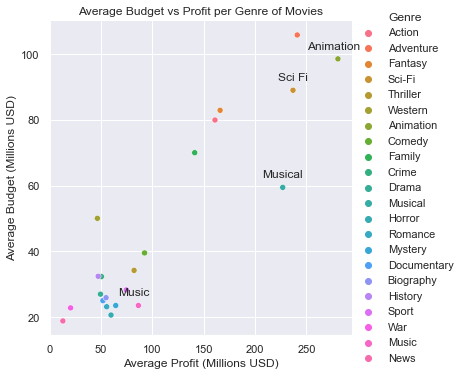

In [13]:
## Creating a scatter plot of Average Budget vs Profit per Genre of Movies
sns.set(font_scale=1)
sns.relplot(data=genre_stats_df, 
            x ="Average_Profit", y="Average_Budget",
            hue = "Genre")
scifi = genre_stats_df[genre_stats_df['Genre'] == 'Sci-Fi']
animate = genre_stats_df[genre_stats_df['Genre'] == 'Animation']
musical = genre_stats_df[genre_stats_df['Genre'] == 'Musical']
music = genre_stats_df[genre_stats_df['Genre'] == 'Music']
plt.text(scifi['Average_Profit']-15, scifi['Average_Budget']+3, 'Sci Fi')
plt.text(animate['Average_Profit']-30, animate['Average_Budget']+3, 'Animation')
plt.text(musical['Average_Profit']-20, musical['Average_Budget']+3, 'Musical')
plt.text(music['Average_Profit']-20, music['Average_Budget']+3, 'Music')



plt.xlabel("Average Profit (Millions USD)")
plt.ylabel("Average Budget (Millions USD)")
plt.title("Average Budget vs Profit per Genre of Movies");

> Now that we have decided Animation is the recomended genre, we will explore budget in relation to only animated movies.

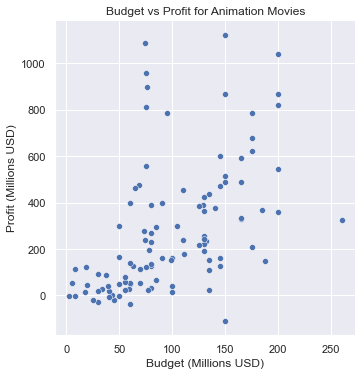

In [14]:
## Creating a scatter plot of Budget vs Profit for Animation Movies
animation.head()
sns.set(font_scale=1)
sns.relplot(data=animation, 
            x ='production_budget_in_millions', y="profit_in_millions")
plt.xlabel("Budget (Millions USD)")
plt.ylabel("Profit (Millions USD)")
plt.title("Budget vs Profit for Animation Movies");

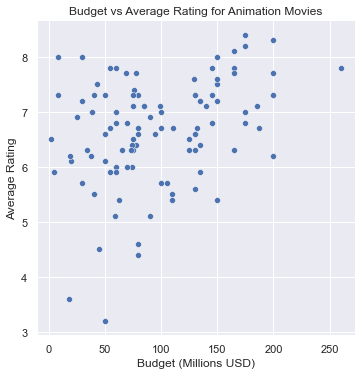

In [15]:
## Creating a scatter plot of Budget vs Average Rating for Animation Movies
sns.set(font_scale=1)
sns.relplot(data=animation, 
            x ="production_budget_in_millions", y="averagerating")
plt.xlabel("Budget (Millions USD)")
plt.ylabel("Average Rating")
plt.title("Budget vs Average Rating for Animation Movies");

> Based on the plots above, it is evident that the higher the budget, the higher the profit.

## Recomendation: Runtime
> Here, we explore the runtime of animated movies for our recomendation

In [16]:
## Creating a dataframe with the top 10 animated movies by profit
df_topanimation = animation.sort_values('profit_in_millions').head(10)

In [17]:
## Looking at statistics for the top 10 profitable animated movies
df_topanimation['runtime_minutes'].describe()

count     10.000000
mean      91.900000
std       11.268935
min       72.000000
25%       87.250000
50%       89.500000
75%      101.250000
max      108.000000
Name: runtime_minutes, dtype: float64

<h4> Boxplot Top Animation Movies based on Profit

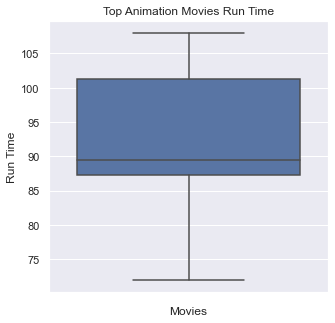

In [18]:
## Creating a box plot of the runtimes of the top 10 profitable animated movies

plt.subplots(figsize=(5, 5))

df_topanimation['runtime_minutes']

sns.boxplot(data= df_topanimation , y = 'runtime_minutes')

plt.xlabel("Movies")
plt.ylabel("Run Time")
plt.title("Top Animation Movies Run Time");

<h5> 50% of the animation movies are between 87 minutes long and 102 minutes long with an average runtime of 91 minutes 

## Recomendation Summary
>### Animated Movies Generate Superior Returns
>### Higher Investment = Higher Returns
>### 87 Minutes to 101 Minutes is the Optimal Runtime

### Other Visulizations

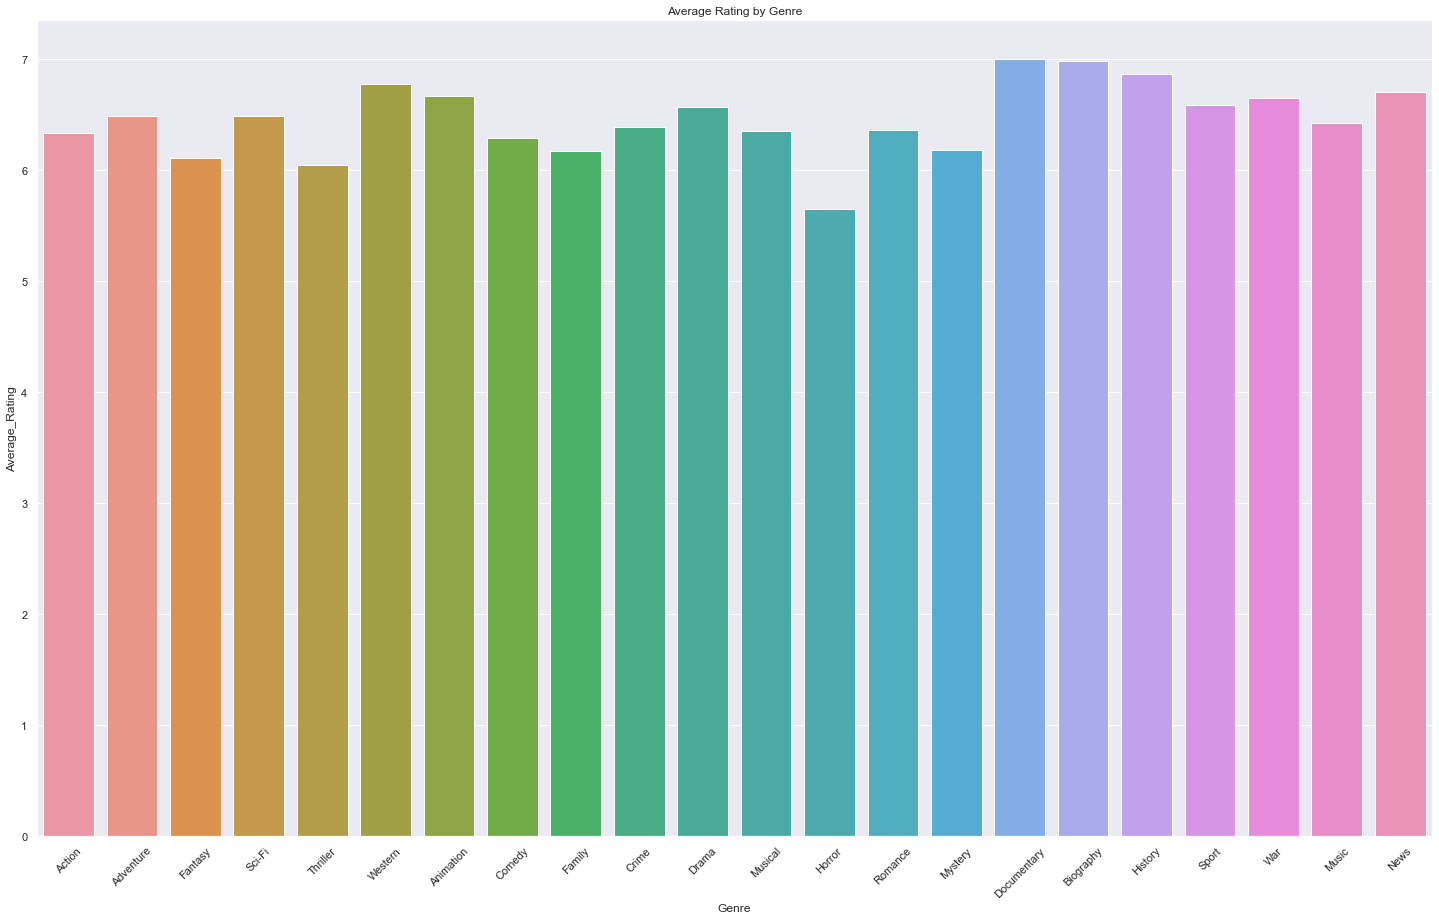

In [19]:
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.title("Average Rating by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Rating');

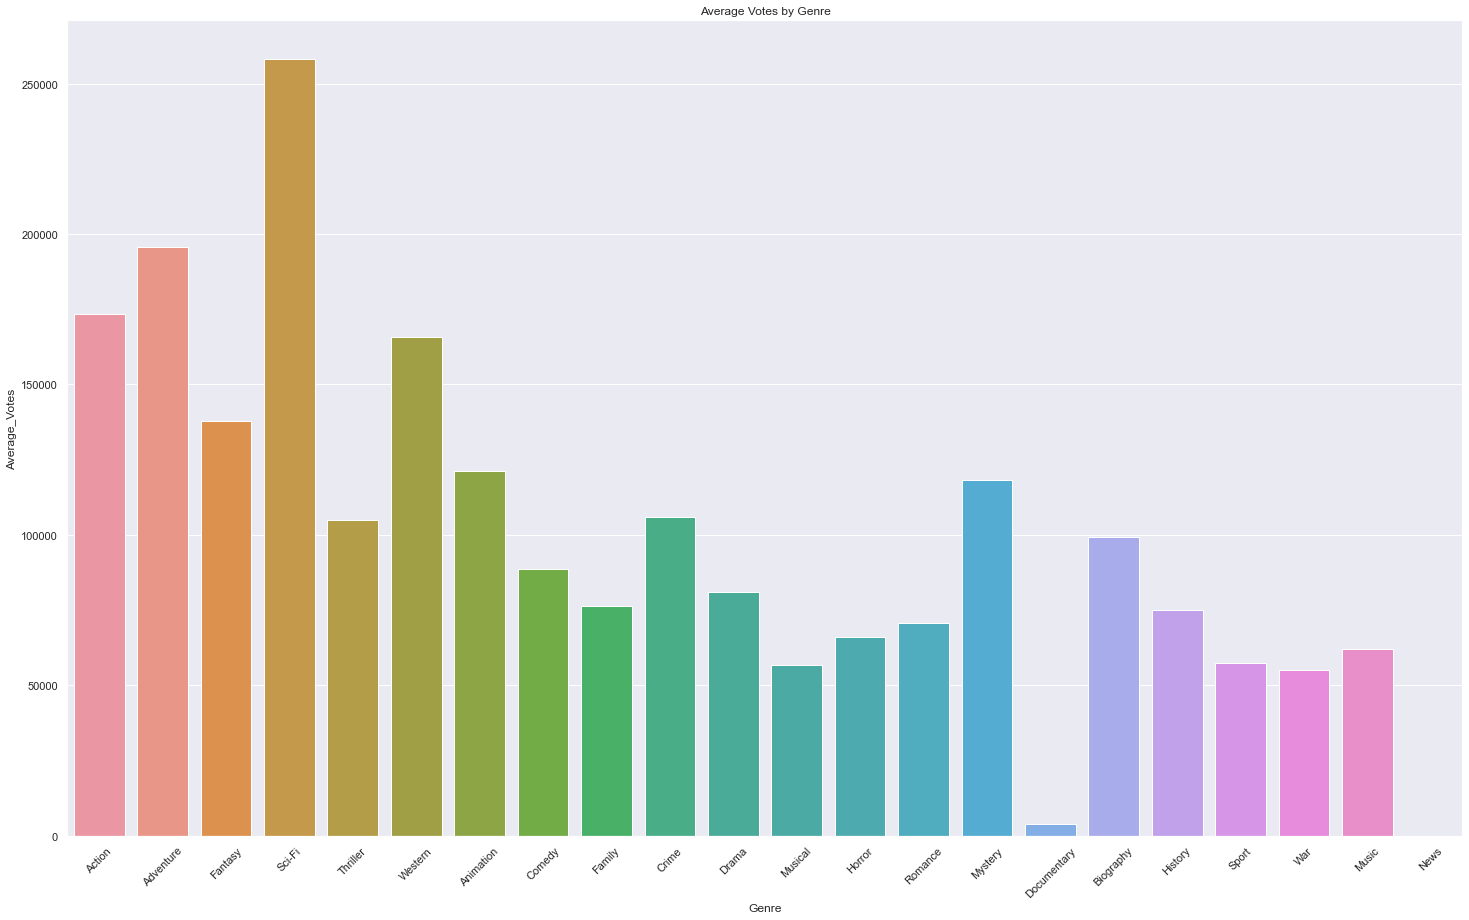

In [20]:
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.title("Average Votes by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Votes');

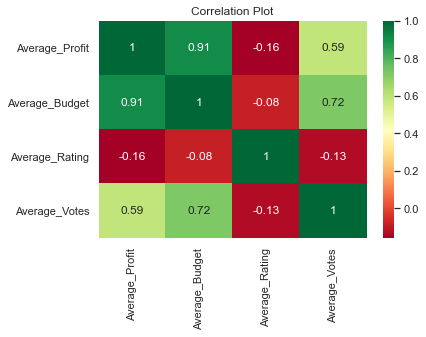

In [21]:
plt.title("Correlation Plot")
sns.heatmap(genre_stats_df.corr().round(2), cmap="RdYlGn", annot=True);

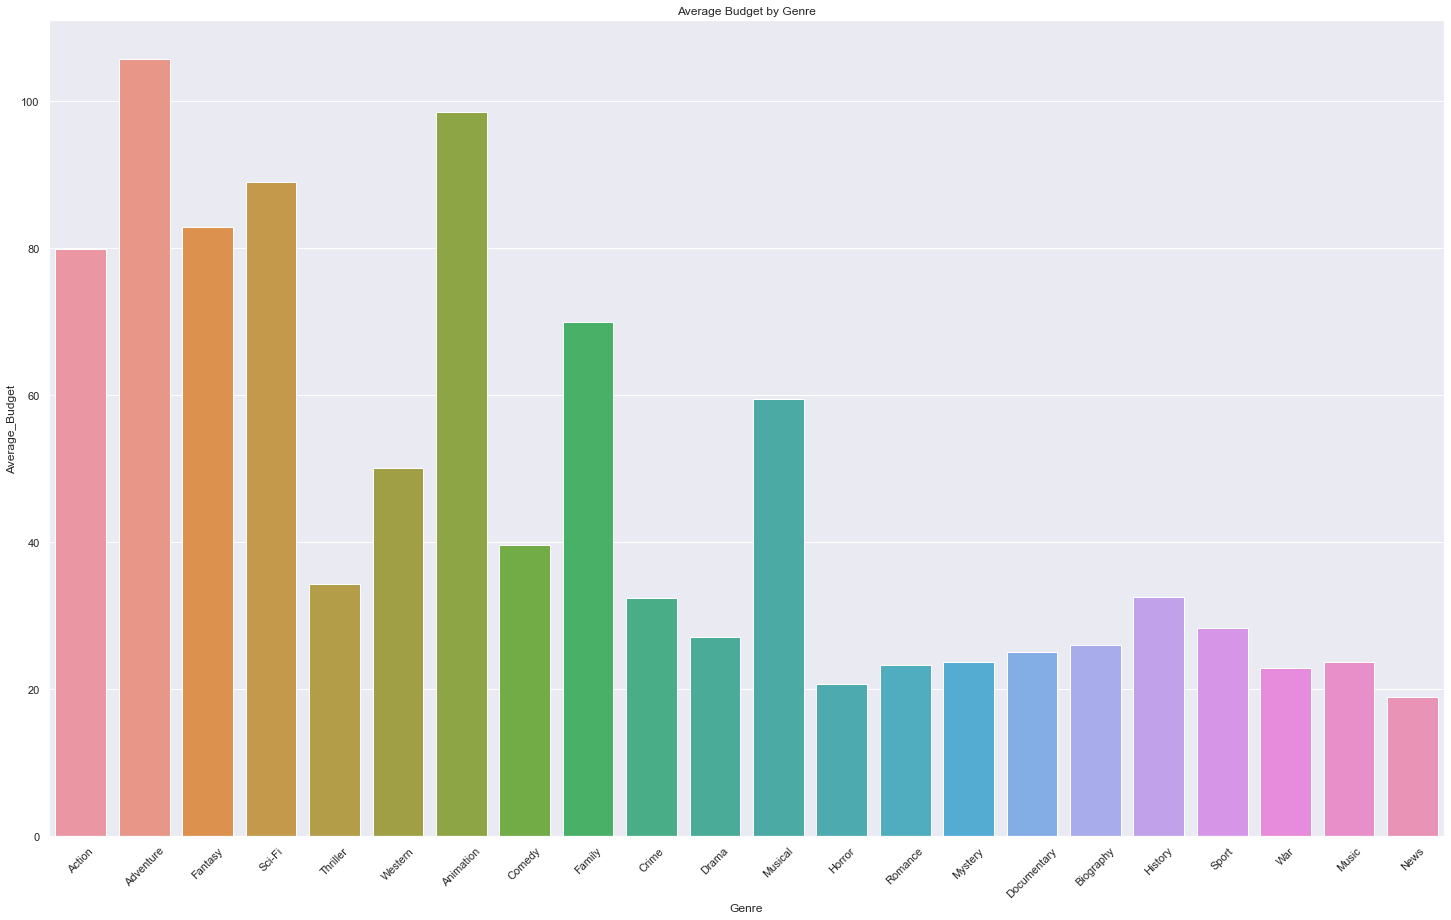

In [22]:
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.title("Average Budget by Genre")
sns.barplot(data = genre_stats_df, x='Genre', y='Average_Budget');

In [23]:
#Querying to find the runtime of the top 10 animation movies by rating 
df_runtime_raw = pd.read_sql('''
SELECT 
    primary_title as "Movie", runtime_minutes as "Run Time"
FROM 
    movie_basics as mb
JOIN
    movie_ratings USING (movie_id)
where 
    genres like "%Animation%"
    and  "Run Time" < 200
AND 
    runtime_minutes != "Nan"
ORDER BY
    averagerating DESC
LIMIT 10
''', conn)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Winning Girl'),
  Text(1, 0, 'Leera the Soulmate'),
  Text(2, 0, 'Man in Camo'),
  Text(3, 0, 'Truth Has Fallen'),
  Text(4, 0, 'Bluefish'),
  Text(5, 0, 'Umbilical World'),
  Text(6, 0, 'Tux and Fanny'),
  Text(7, 0, 'Doraleous and Associates'),
  Text(8, 0, 'Mushi-Shi Zoku Shou: Suzu no Shizuku'),
  Text(9, 0, 'Pequenas voces 3d')])

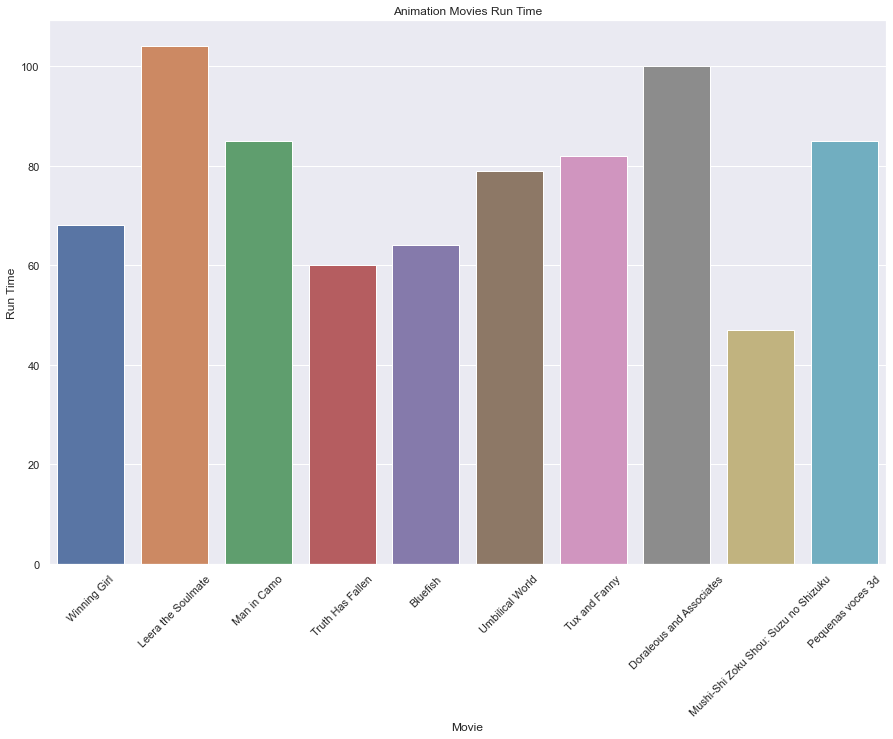

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data = df_runtime_raw, x='Movie', y='Run Time')
plt.xlabel("Movie")
plt.ylabel("Run Time")
plt.title("Animation Movies Run Time")
plt.xticks(rotation = 45)
#plotting our movies from above